In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


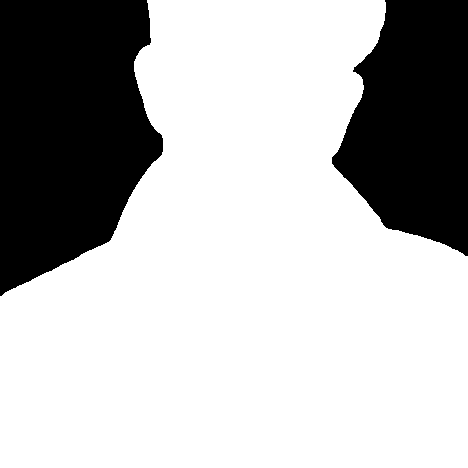

100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
#from metrics import dice_loss, dice_coef, iou

""" Global parameters """
H = 512
W = 512

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("remove_bg")

    """ Loading model: DeepLabV3+ """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Data Science/model (2).h5")

    # model.summary()

    """ Load the dataset """
    data_x = glob("/content/Hrithik-Roshan.jpg")

    for path in tqdm(data_x, total=len(data_x)):
         """ Extracting name """
         name = path.split("/")[-1].split(".")[0]

         """ Read the image """
         image = cv2.imread(path, cv2.IMREAD_COLOR)
         h, w, _ = image.shape
         x = cv2.resize(image, (W, H))
         x = x/255.0
         x = x.astype(np.float32)
         x = np.expand_dims(x, axis=0)

         """ Prediction """
         y = model.predict(x)[0]
         y = cv2.resize(y, (w, h))
         y = np.expand_dims(y, axis=-1)
         y = y > 0.5

         photo_mask = y
         background_mask = np.abs(1-y)

         # cv2.imwrite(f"remove_bg/{name}.png", photo_mask*255)
         # cv2.imwrite(f"remove_bg/{name}.png", background_mask*255)

         # cv2.imwrite(f"remove_bg/{name}.png", image * photo_mask)
         # cv2.imwrite(f"remove_bg/{name}.png", image * background_mask)

         masked_photo = image * photo_mask
         background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
         background_mask = background_mask * [0, 0, 255]
         final_photo = masked_photo + background_mask
         from google.colab.patches import cv2_imshow
         cv2_imshow(photo_mask*255)

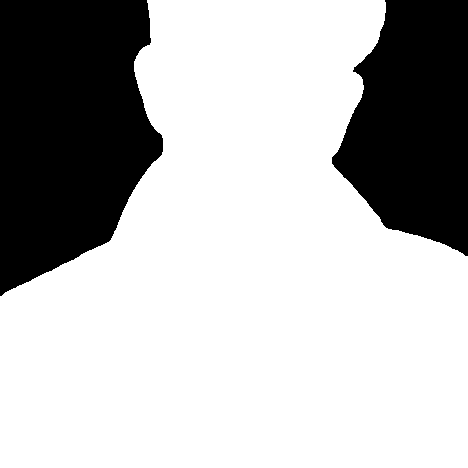

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(photo_mask*255)

In [ ]:
a=background_mask*255

In [ ]:
type(a)

numpy.ndarray